In [53]:
import numpy as np
import math
import time

def CIM_CAC_CPU(T_time, J, batch_size=1, time_step=0.05, r=None, alpha=3.0, beta=0.25, gamma=0.00011, delta=10, mu=1, rho=3, tau=1000, noise=0, H0=None, cac_nonlinearity=np.tanh):
    """CIM solver with chaotic amplitude control; no external h field, adapted for CPU with NumPy arrays."""

    # Compute instance sizes
    N = J.shape[1]
    if r is None:
        r = 0.8 - (N / 220) ** 2

    # Initialize data arrays
    xi = np.zeros(batch_size)
    t_c = np.zeros(batch_size)
    H = np.zeros(batch_size)
    spin_amplitude_trajectory = np.zeros((batch_size, N, T_time))
    error_var_data = np.zeros((batch_size, N, T_time))
    energy_plot_data = np.zeros((batch_size, T_time))
    t_opt = np.zeros(batch_size)

    # Initialize Spin-Amplitude Vectors and Auxiliary Variables
    x = 0.001 * np.random.rand(batch_size, N) - 0.0005
    error_var = np.ones((batch_size, N))
    effective_tau = tau / time_step

    # Configure ramp schedules
    beta = np.ones(T_time) * beta
    r = np.ones(T_time) * r

    # Compute initial Ising energy and spin states
    sig = 2 * (x > 0) - 1
    H = -0.5 * np.sum(sig * (sig @ J), axis=1)

    H_opt = H.copy()
    sig_opt = sig.copy()
    a = alpha * np.ones(batch_size) 

    # Simulate Time-Evolution of Spin Amplitudes
    for t in range(T_time):
        x_ = x.copy()
        spin_amplitude_trajectory[:, :, t] = x_
        error_var_data[:, :, t] = error_var
        sig = 2 * (x > 0) - 1
        H = -0.5 * np.sum(sig * (sig @ J), axis=1)
        
        # Euler step for equations of motion of spin amplitudes
        MVM = x @ J
        x += time_step * (x * ((r[t] - 1) - mu * x**2)) 
        x += time_step * beta[t] * MVM * error_var
        x += beta[t] * noise * (np.random.rand(*x.shape) - 0.5)  # Adding noise term

        # Save current Ising energy
        energy_plot_data[:, t] = H

        # Euler step for equations of motion of error variables
        delta_e = -xi * (x_ ** 2 - a) * error_var
        error_var += delta_e * time_step

        # Normalize auxiliary error variables
        # error_var[error_var > 32] = 32

        # Modulate target amplitude, error variable rate of change parameters depending on Ising energy
        xi += gamma * time_step
        dH = H - H_opt
        a = alpha + rho * cac_nonlinearity(delta * dH)

        # Update ramp schedules and minimum Ising energy
        # t_c[t_c < t - effective_tau] = t
        # xi[t_c < t - effective_tau] = 0
        # t_opt[H < H_opt] = t
        # t_c[H < H_opt] = t
        H_opt = np.minimum(H_opt, H)

    # Parse and Return Solutions
    spin_plot_data = 2 * (spin_amplitude_trajectory > 0) - 1

    for k in range(batch_size):
        sig_opt[k, :] = spin_plot_data[k, :, int(t_opt[k])]

    return sig_opt, spin_amplitude_trajectory, T_time, energy_plot_data, error_var_data


In [56]:
Time = 3000
J = - np.load('MC50_N=10_2.npz')
solve = CIM_CAC_CPU(Time, J)
spin_config = solve[0]
x_trajectory = solve[1]
T_time = solve[2]
ground_state = solve[3]
error_var = solve[4]

print('spin configuration:', spin_config)
print('spin amplitude trajectory:', x_trajectory.shape)
print('time:', T_time)
print('ground state:', np.min(ground_state))
print('max error variance:', np.max(error_var))

spin configuration: [[ 1 -1 -1 -1  1 -1  1  1 -1 -1]]
spin amplitude trajectory: (1, 10, 3000)
time: 3000
ground state: -9.0
max error variance: 18.603907950392124


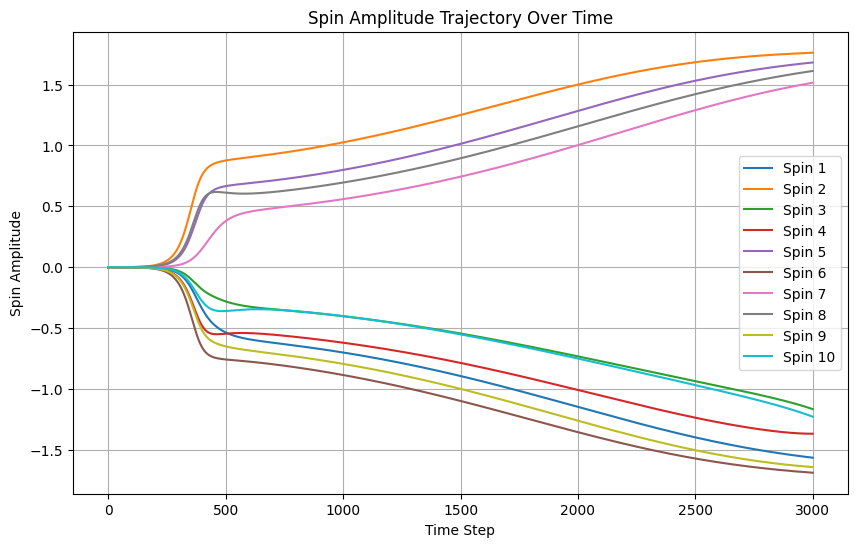

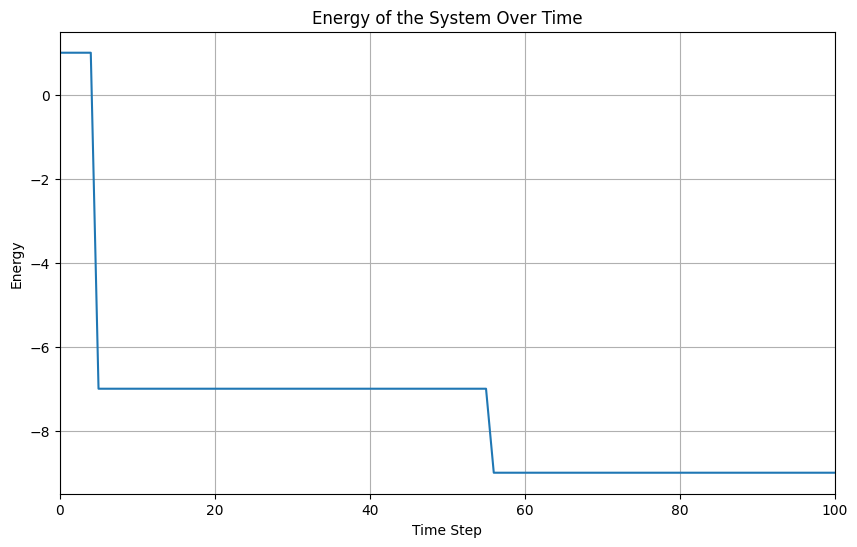

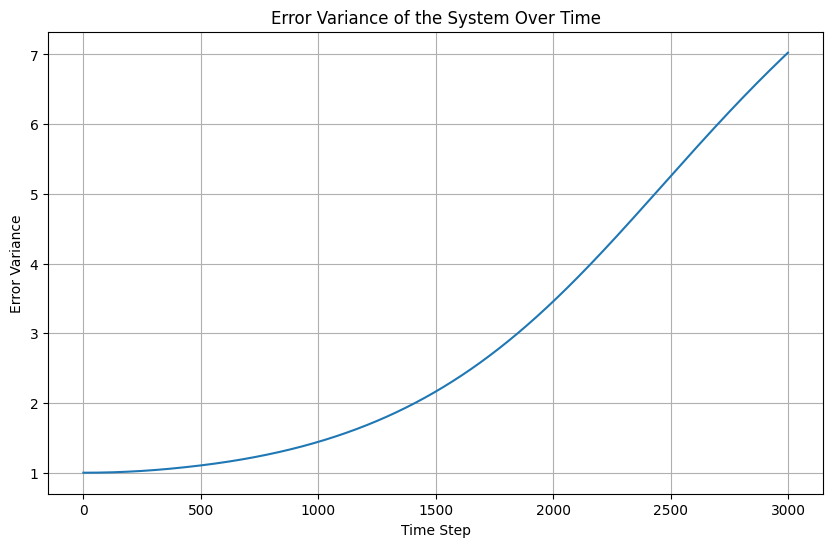

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for spin_index in range(10):

    # Extract the amplitude trajectory for the chosen spin
    amplitude_trajectory = x_trajectory[0, spin_index, :]

    # Create the plot
    plt.plot(np.arange(T_time), amplitude_trajectory, label=f'Spin {spin_index + 1}')
    plt.xlabel('Time Step')
    plt.ylabel('Spin Amplitude')
    plt.title('Spin Amplitude Trajectory Over Time')
    plt.legend()
    plt.grid(True)
plt.show()

# # plot the energy of the system over time
plt.figure(figsize=(10, 6))
plt.plot(np.arange(T_time), ground_state[0, :])
plt.xlabel('Time Step')
plt.ylabel('Energy')
plt.title('Energy of the System Over Time')
plt.grid(True)
plt.xlim(0,100)
plt.show()

# # plot the error variance of the system over time
plt.figure(figsize=(10, 6))
plt.plot(np.arange(T_time), error_var[0, 0, :])
plt.xlabel('Time Step')
plt.ylabel('Error Variance')
plt.title('Error Variance of the System Over Time')
plt.grid(True)
plt.show()



## Generate Mobius Ladder N=8

[[ 0. -1.  0.  0. -1.  0.  0. -1.]
 [-1.  0. -1.  0.  0. -1.  0.  0.]
 [ 0. -1.  0. -1.  0.  0. -1.  0.]
 [ 0.  0. -1.  0. -1.  0.  0. -1.]
 [-1.  0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1.  0.  0. -1.  0. -1.  0.]
 [ 0.  0. -1.  0.  0. -1.  0. -1.]
 [-1.  0.  0. -1.  0.  0. -1.  0.]]


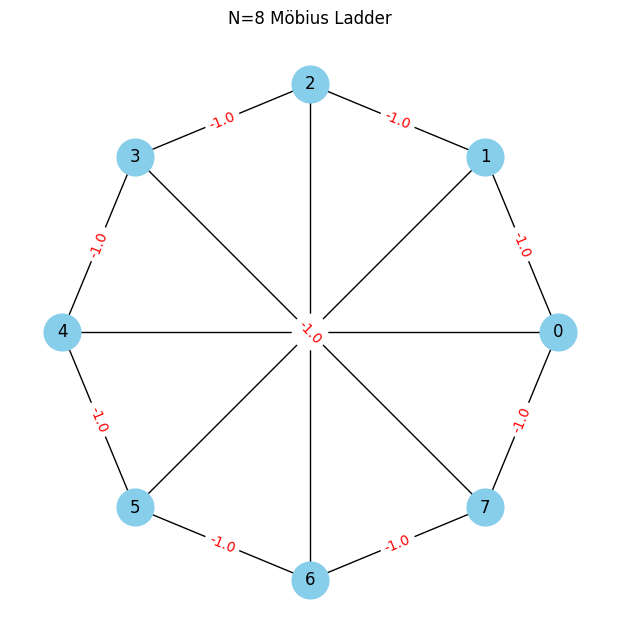

In [58]:
# Initialize the J matrix for the Möbius ladder with zeros
J_mobius = np.zeros((8, 8))

# Set the nearest neighbor interactions and the "rung" interactions
for i in range(8):
    J_mobius[i, (i-1) % 8] = -1  # Interaction with the previous spin
    J_mobius[i, (i+1) % 8] = -1  # Interaction with the next spin
    if i < 4:  # "Rung" interactions, avoiding duplicate entries
        J_mobius[i, (i+4) % 8] = -1
        J_mobius[(i+4) % 8, i] = -1  # Ensure the matrix is symmetric

print(J_mobius)

import networkx as nx
import matplotlib.pyplot as plt

# Initialize a new graph for the Möbius ladder based on the J-matrix
G_J_mobius = nx.Graph()

# Add nodes to the graph
for i in range(8):
    G_J_mobius.add_node(i)

# Add edges based on the J-matrix, considering only the upper triangle to avoid duplicates
for i in range(8):
    for j in range(i+1, 8):
        if J_mobius[i, j] != 0:
            G_J_mobius.add_edge(i, j, weight=J_mobius[i, j])

# Draw the graph with a circular layout to represent the Möbius ladder structure
pos_J_mobius = nx.circular_layout(G_J_mobius)  # Use a circular layout for the nodes

plt.figure(figsize=(6, 6))
nx.draw(G_J_mobius, pos_J_mobius, with_labels=True, node_color='skyblue', node_size=700, edge_color='black')
edge_labels = nx.get_edge_attributes(G_J_mobius, 'weight')
nx.draw_networkx_edge_labels(G_J_mobius, pos_J_mobius, edge_labels=edge_labels, font_color='red')
plt.title("N=8 Möbius Ladder")
plt.show()


In [59]:
Time = 1000
solve = CIM_CAC_CPU(Time, J_mobius)
spin_config = solve[0]
x_trajectory = solve[1]
T_time = solve[2]
ground_state = solve[3]
error_var = solve[4]

print('spin configuration:', spin_config)
print('spin amplitude trajectory:', x_trajectory.shape)
print('time:', T_time)
print('ground state:', np.min(ground_state))
print('max error variance:', np.max(error_var))

spin configuration: [[-1  1  1 -1  1 -1  1 -1]]
spin amplitude trajectory: (1, 8, 1000)
time: 1000
ground state: -8.0
max error variance: 1.4657560445032882


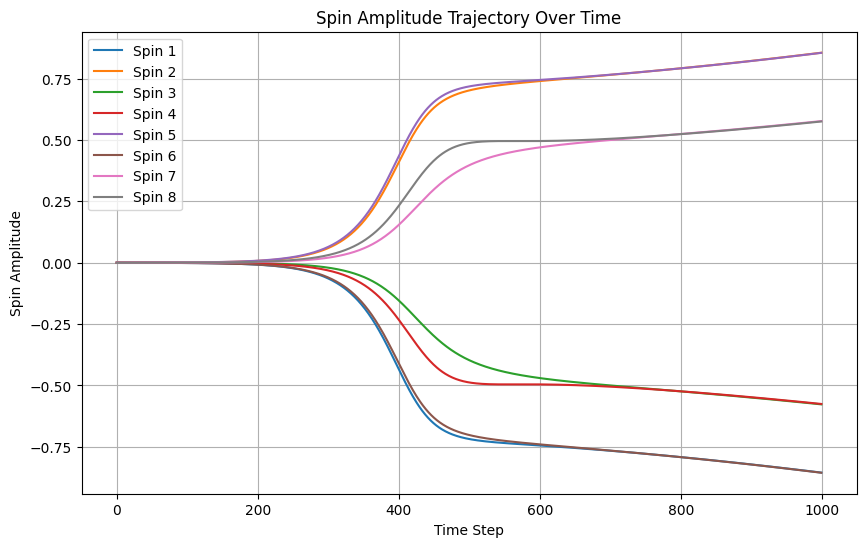

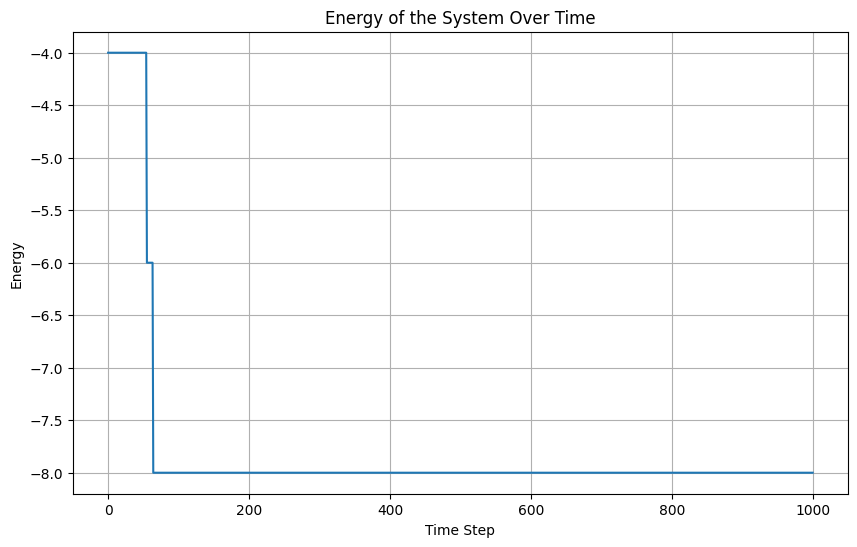

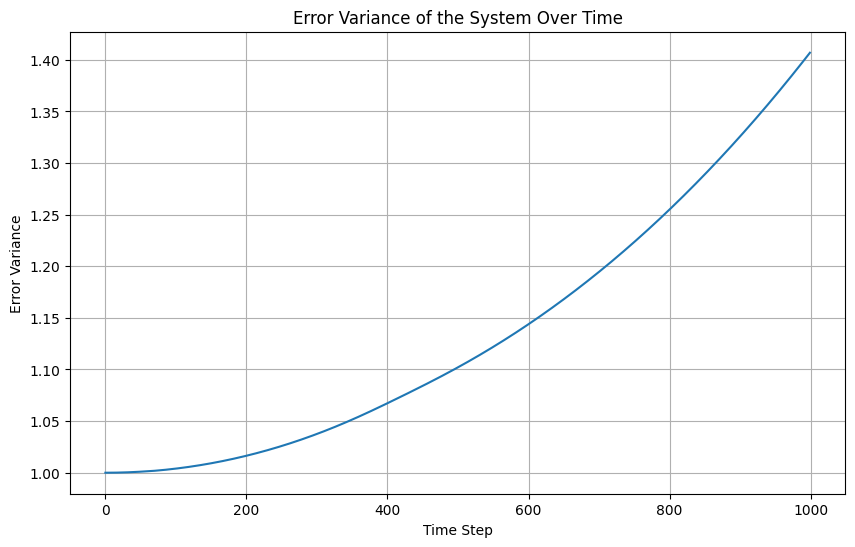

In [60]:
plt.figure(figsize=(10, 6))
for spin_index in range(8):

    # Extract the amplitude trajectory for the chosen spin
    amplitude_trajectory = x_trajectory[0, spin_index, :]

    # Create the plot
    plt.plot(np.arange(T_time), amplitude_trajectory, label=f'Spin {spin_index + 1}')
    plt.xlabel('Time Step')
    plt.ylabel('Spin Amplitude')
    plt.title('Spin Amplitude Trajectory Over Time')
    plt.legend()
    plt.grid(True)
plt.show()

# # plot the energy of the system over time
plt.figure(figsize=(10, 6))
plt.plot(np.arange(T_time), ground_state[0, :])
plt.xlabel('Time Step')
plt.ylabel('Energy')
plt.title('Energy of the System Over Time')
plt.grid(True)
plt.show()

# # plot the error variance of the system over time
plt.figure(figsize=(10, 6))
plt.plot(np.arange(T_time), error_var[0, 0, :])
plt.xlabel('Time Step')
plt.ylabel('Error Variance')
plt.title('Error Variance of the System Over Time')
plt.grid(True)
plt.show()


# Try Gset

In [61]:
# Open the provided file and read its contents
file_path = 'G1.txt'

edges = []

with open(file_path, 'r') as file:
    next(file)  # Skip the first row
    for line in file:
        node1, node2, weight = map(int, line.split())  # Convert strings to integers
        edges.append((node1 - 1, node2 - 1, weight))  # Adjust for 0-based indexing

# Determine the number of nodes
num_nodes = max(max(edge[0], edge[1]) for edge in edges) + 1

# Initialize the J matrix with zeros
J_matrix = np.zeros((num_nodes, num_nodes))

# Populate the J matrix based on the edges
for node1, node2, weight in edges:
    J_matrix[node1, node2] = weight
    J_matrix[node2, node1] = weight  # For undirected graphs

# Convert interaction strengths to negative values
J_matrix = -J_matrix

# Saving the J matrix to a new text file as instructed
np.savetxt('G1_J_matrix.txt', J_matrix, fmt='%d')


In [62]:
Time = 1000
solve = CIM_CAC_CPU(Time, J_matrix)
spin_config = solve[0]
x_trajectory = solve[1]
T_time = solve[2]
ground_state = solve[3]
error_var = solve[4]

# print('spin configuration:', spin_config)
print('spin amplitude trajectory:', x_trajectory.shape)
print('time:', T_time)
print('ground state:', np.min(ground_state))
print('max error variance:', np.max(error_var))

spin amplitude trajectory: (1, 800, 1000)
time: 1000
ground state: -3466.0
max error variance: 2.214936587735207


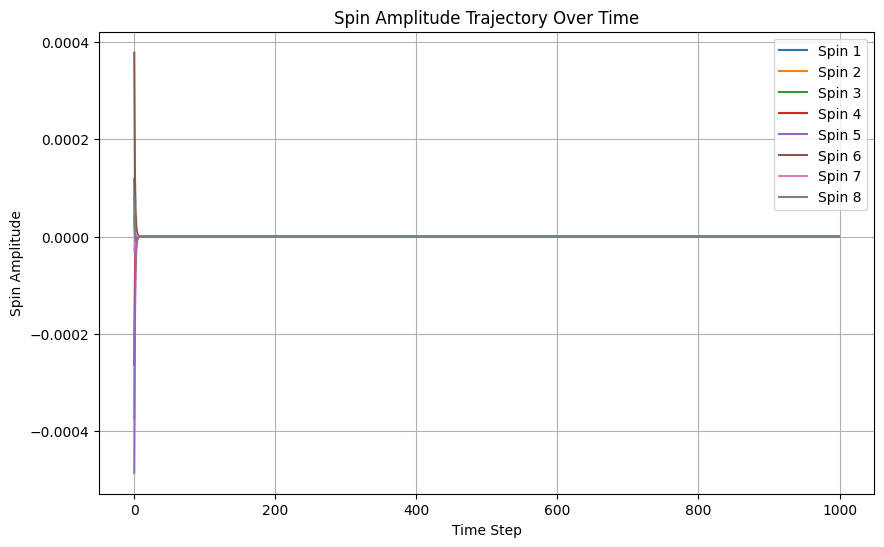

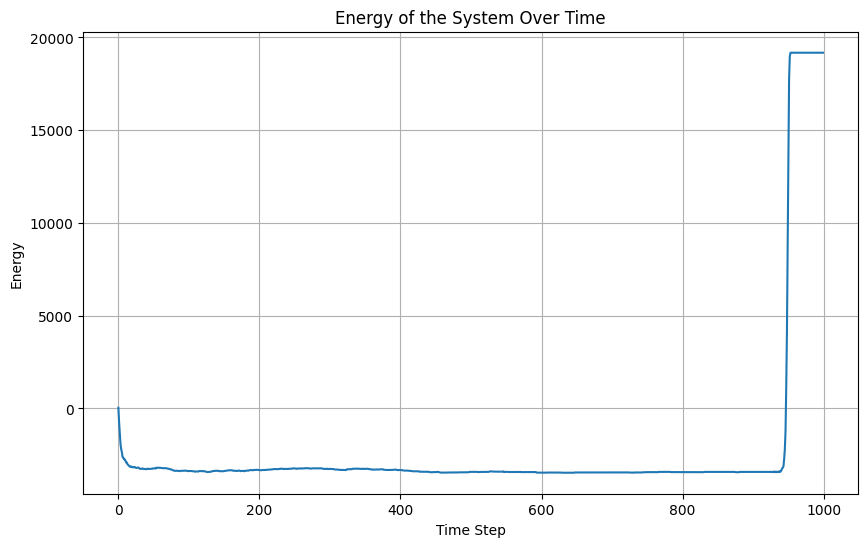

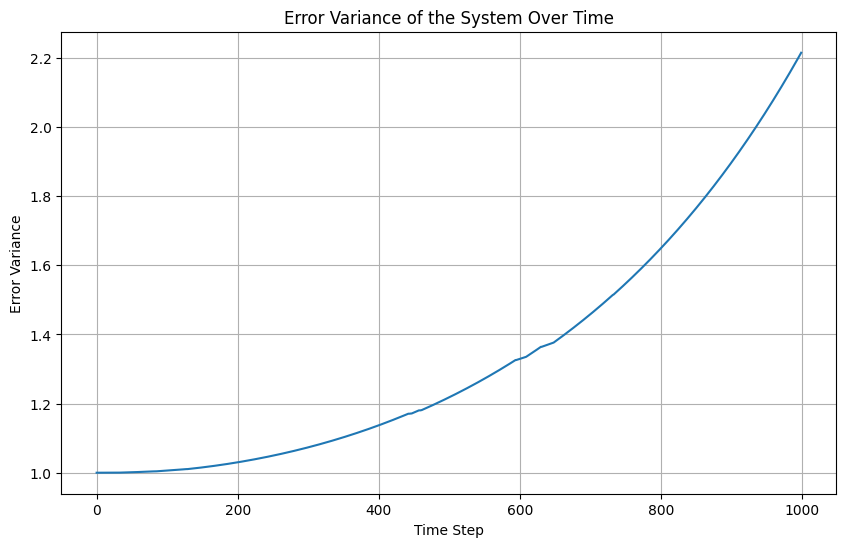

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for spin_index in range(8):

    # Extract the amplitude trajectory for the chosen spin
    amplitude_trajectory = x_trajectory[0, spin_index, :]

    # Create the plot
    plt.plot(np.arange(T_time), amplitude_trajectory, label=f'Spin {spin_index + 1}')
    plt.xlabel('Time Step')
    plt.ylabel('Spin Amplitude')
    plt.title('Spin Amplitude Trajectory Over Time')
    plt.legend()
    plt.grid(True)
plt.show()

# # plot the energy of the system over time
plt.figure(figsize=(10, 6))
plt.plot(np.arange(T_time), ground_state[0, :])
plt.xlabel('Time Step')
plt.ylabel('Energy')
plt.title('Energy of the System Over Time')
plt.grid(True)
plt.show()

# # plot the error variance of the system over time
plt.figure(figsize=(10, 6))
plt.plot(np.arange(T_time), error_var[0, 0, :])
plt.xlabel('Time Step')
plt.ylabel('Error Variance')
plt.title('Error Variance of the System Over Time')
plt.grid(True)
plt.show()
